In [1]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("alzheimer.csv") 

In [3]:
data['MMSE'].fillna(data['MMSE'].median(), inplace=True)

data['Group'] = LabelEncoder().fit_transform(data['Group'])  # Demented = 1, Nondemented = 0
data['M/F'] = LabelEncoder().fit_transform(data['M/F'])  # Male = 0, Female = 1

/var/folders/xl/6cfby_3j5nnfxbpq42y22zhr0000gn/T/ipykernel_7852/2704752447.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['MMSE'].fillna(data['MMSE'].median(), inplace=True)


In [6]:
from sklearn.impute import SimpleImputer

# Define imputer (filling NaNs with the median)
imputer = SimpleImputer(strategy='median')

# Apply imputer to selected features
data[features] = imputer.fit_transform(data[features])

# Now, apply PolynomialFeatures
X = poly.fit_transform(data[features])

In [7]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
features = ['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
X = poly.fit_transform(data[features])
y = data['Group']


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
def objective(trial):
    model_type = trial.suggest_categorical("model_type", ["RandomForest", "XGBoost", "LightGBM", "MLP"])
    
    if model_type == "RandomForest":
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 300, step=50),
            max_depth=trial.suggest_int("max_depth", 10, 30, step=5),
            random_state=42
        )
    elif model_type == "XGBoost":
        model = XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 300, step=50),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3)
        )
    elif model_type == "LightGBM":
        model = LGBMClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 300, step=50),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3)
        )
    else:
        model = MLPClassifier(
            hidden_layer_sizes=(trial.suggest_int("hidden_units", 50, 200),),
            activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
            alpha=trial.suggest_float("alpha", 0.0001, 0.01),
            max_iter=500
        )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_model_type = study.best_params['model_type']
print(f"Best Model: {best_model_type}")
print(f"Best Accuracy: {study.best_value:.2f}")

[I 2025-04-04 17:20:14,733] A new study created in memory with name: no-name-cd33656b-7e2a-479d-a7b1-a8f00dad30f3
[I 2025-04-04 17:20:15,039] Trial 0 finished with value: 0.8666666666666667 and parameters: {'model_type': 'MLP', 'hidden_units': 151, 'activation': 'relu', 'alpha': 0.0015213532126452103}. Best is trial 0 with value: 0.8666666666666667.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 298, number of used features: 45
[LightGBM] [Info] Start training from score -2.329798
[LightGBM] [Info] Start training from score -0.934920
[LightGBM] [Info] Start training from score -0.673213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-04 17:20:15,367] Trial 1 finished with value: 0.92 and parameters: {'model_type': 'LightGBM', 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.291035229357182}. Best is trial 1 with value: 0.92.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-04 17:20:15,861] Trial 2 finished with value: 0.9333333333333333 and parameters: {'model_type': 'XGBoost', 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.12390037649910443}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 298, number of used features: 45
[LightGBM] [Info] Start training from score -2.329798
[LightGBM] [Info] Start training from score -0.934920
[LightGBM] [Info] Start training from score -0.673213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-04 17:20:16,237] Trial 3 finished with value: 0.92 and parameters: {'model_type': 'LightGBM', 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.11893225346852156}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-04 17:20:16,507] Trial 4 finished with value: 0.92 and parameters: {'model_type': 'XGBoost', 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.2238929602337265}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 298, number of used features: 45
[LightGBM] [Info] Start training from score -2.329798
[LightGBM] [Info] Start training from score -0.934920
[LightGBM] [Info] Start training from score -0.673213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-04 17:20:16,837] Trial 5 finished with value: 0.92 and parameters: {'model_type': 'LightGBM', 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1607433391745926}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-04 17:20:17,100] Trial 6 finished with value: 0.92 and parameters: {'model_type': 'XGBoost', 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.22688268977092307}. Best is trial 2 with value: 0.9333333333333333.
[I 2025-04-04 17:20:17,346] Trial 7 finished with value: 0.92 and parameters: {'model_type': 'XGBoost', 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.14515427736287492}. Best is trial 2 with value: 0.9333333333333333.
/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-04-04 17:20:17,575] Trial 8 finished with value: 0.8933333333333333 and parameters: {'model_type': 'MLP', 'hidden_units': 69, 'activation': 'tanh', 'alpha': 0.008704995605461001}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 298, number of used features: 45
[LightGBM] [Info] Start training from score -2.329798
[LightGBM] [Info] Start training from score -0.934920
[LightGBM] [Info] Start training from score -0.673213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-04 17:20:17,914] Trial 9 finished with value: 0.92 and parameters: {'model_type': 'LightGBM', 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.24599373310909803}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-04 17:20:18,262] Trial 10 finished with value: 0.92 and parameters: {'model_type': 'RandomForest', 'n_estimators': 300, 'max_depth': 30}. Best is trial 2 with value: 0.9333333333333333.
[I 2025-04-04 17:20:18,517] Trial 11 finished with value: 0.92 and parameters: {'model_type': 'RandomForest', 'n_estimators': 300, 'max_depth': 20}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 298, number of used features: 45
[LightGBM] [Info] Start training from score -2.329798
[LightGBM] [Info] Start training from score -0.934920
[LightGBM] [Info] Start training from score -0.673213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-04 17:20:19,617] Trial 12 finished with value: 0.9333333333333333 and parameters: {'model_type': 'LightGBM', 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.02594675400252766}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-04 17:20:20,378] Trial 13 finished with value: 0.9066666666666666 and parameters: {'model_type': 'XGBoost', 'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.043343119996405124}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 298, number of used features: 45
[LightGBM] [Info] Start training from score -2.329798
[LightGBM] [Info] Start training from score -0.934920
[LightGBM] [Info] Start training from score -0.673213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-04 17:20:21,282] Trial 14 finished with value: 0.92 and parameters: {'model_type': 'LightGBM', 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.011035736898983744}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-04 17:20:21,822] Trial 15 finished with value: 0.9333333333333333 and parameters: {'model_type': 'XGBoost', 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.09210309359262092}. Best is trial 2 with value: 0.9333333333333333.
/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-04-04 17:20:22,200] Trial 16 finished with value: 0.8933333333333333 and parameters: {'model_type': 'MLP', 'hidden_units': 195, 'activation': 'tanh', 'alpha': 0.00017267966056385125}. Best is trial 2 with value: 0.9333333333333333.
[I 2025-04-04 17:20:22,361] Trial 17 finished with value: 0.92 and parameters: {'model_type': 'RandomForest', 'n_estimators': 200, 'max_depth': 15}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 298, number of used features: 45
[LightGBM] [Info] Start training from score -2.329798
[LightGBM] [Info] Start training from score -0.934920
[LightGBM] [Info] Start training from score -0.673213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/Users/udaysharma/Desktop/akrit/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-04-04 17:20:23,345] Trial 18 finished with value: 0.92 and parameters: {'model_type': 'LightGBM', 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.06193929108232575}. Best is trial 2 with value: 0.9333333333333333.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-04 17:20:23,730] Trial 19 finished with value: 0.92 and parameters: {'model_type': 'XGBoost', 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1757368738490776}. Best is trial 2 with value: 0.9333333333333333.


Best Model: XGBoost
Best Accuracy: 0.93


In [11]:
if best_model_type == "RandomForest":
    best_model = RandomForestClassifier(**{k: v for k, v in study.best_params.items() if k != 'model_type'}, random_state=42)
elif best_model_type == "XGBoost":
    best_model = XGBClassifier(**{k: v for k, v in study.best_params.items() if k != 'model_type'})
elif best_model_type == "LightGBM":
    best_model = LGBMClassifier(**{k: v for k, v in study.best_params.items() if k != 'model_type'})
else:
    best_model = MLPClassifier(**{k: v for k, v in study.best_params.items() if k != 'model_type'}, max_iter=500)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.97      1.00      0.98        29
           2       0.90      1.00      0.95        38

    accuracy                           0.93        75
   macro avg       0.96      0.79      0.83        75
weighted avg       0.94      0.93      0.92        75



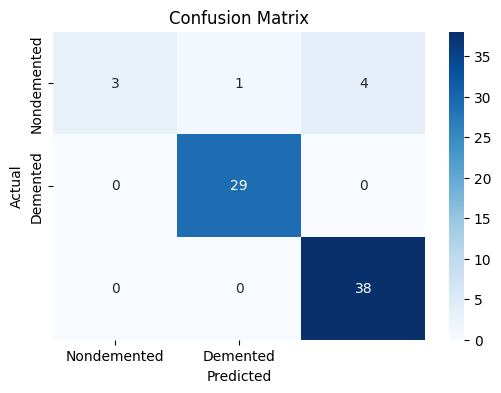

In [12]:
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Nondemented', 'Demented'], yticklabels=['Nondemented', 'Demented'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

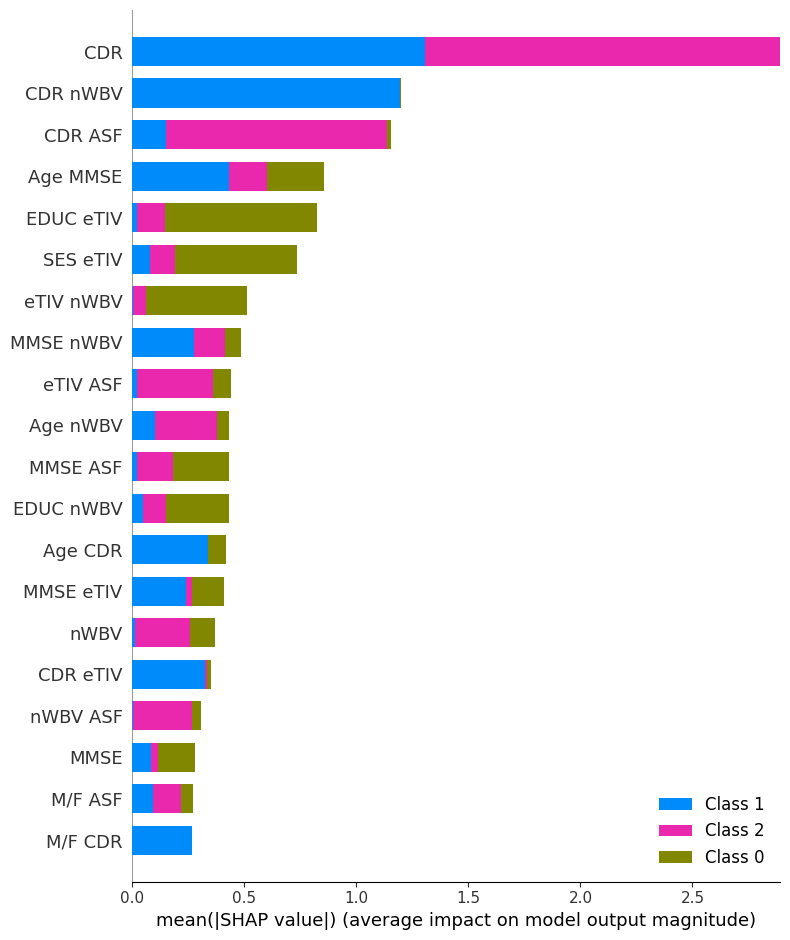

Recommended Treatment: Mild Dementia: Cholinesterase Inhibitors, Cognitive Therapy, Diet Improvement


In [13]:
if best_model_type in ["RandomForest", "XGBoost", "LightGBM"]:
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=poly.get_feature_names_out(features))

def recommend_treatment(mmse, cdr, age, educ, prev_treatment=None):
    if prev_treatment:
        return "Personalized Treatment Plan Needed - Consult Specialist"
    
    if mmse >= 27 and cdr == 0.0:
        return "No Treatment Needed"
    elif mmse >= 24 and cdr == 0.5:
        return "Early Intervention: Cognitive Training, Lifestyle Changes, Vitamin Supplements"
    elif mmse >= 18 and cdr == 1.0:
        return "Mild Dementia: Cholinesterase Inhibitors, Cognitive Therapy, Diet Improvement"
    elif mmse >= 10 and cdr == 2.0:
        return "Moderate Dementia: Memantine, Behavioral Therapy, Assisted Living Options"
    elif mmse < 10 or cdr >= 3.0:
        return "Severe Dementia: Full-time Care, Palliative Treatment, Hospice Support"
    return "Consult Neurologist for Personalized Plan"

sample_patient = {'MMSE': 22, 'CDR': 1.0, 'Age': 75, 'EDUC': 12, 'Prev_Treatment': None}
print(f"Recommended Treatment: {recommend_treatment(sample_patient['MMSE'], sample_patient['CDR'], sample_patient['Age'], sample_patient['EDUC'], sample_patient['Prev_Treatment'])}")


In [14]:
import joblib
joblib.dump(best_model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(poly, "poly.pkl")


['poly.pkl']